## 1.2 Install, load libraries

In [ ]:
!pip install wandb

In [2]:
import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
# Login to Weights & Biases
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 1.3 Test evaluation

### 1.3.1 Definition of the base classes

This is necessary in order to ```joblib.load()```see the previous definitions used in the Train Pipeline.

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # update column names
        self.colnames = df.columns

        return df
        
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

### 1.3.2 Evaluation

In [5]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "decision_tree/test.csv:latest"

# name of the model artifact
artifact_model_name = "decision_tree/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name = "decision_tree/target_encoder:latest"

In [6]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [7]:
# initiate the wandb project
run = wandb.init(project="decision_tree",job_type="test")

wandb: Currently logged in as: araujo-marcos. Use `wandb login --relogin` to force relogin


In [9]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("y")

06-06-2022 15:47:26 Downloading and reading test artifact
06-06-2022 15:47:26 Extracting target from dataframe


In [10]:
# Takes a look at test set
x_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,31,entrepreneur,single,tertiary,no,206,no,no,cellular,15,jun,88,2,-1,0,unknown
1,31,management,single,tertiary,no,499,yes,no,unknown,9,jun,122,2,-1,0,unknown
2,44,technician,married,tertiary,no,4580,yes,no,cellular,20,nov,192,2,189,2,success
3,49,management,married,tertiary,no,176,yes,yes,cellular,14,jul,102,2,-1,0,unknown
4,28,blue-collar,single,primary,no,442,no,no,cellular,30,jan,157,2,-1,0,unknown


In [12]:
# Take a look at the target variable
y_test.head(10)

0     no
1     no
2     no
3     no
4     no
5     no
6     no
7     no
8    yes
9     no
Name: y, dtype: object

In [13]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

06-06-2022 15:48:19 Extracting the encoding of the target variable


In [14]:
# transform y_train
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

06-06-2022 15:48:45 Classes [0, 1]: ['no' 'yes']


In [15]:
# target variable after the encoding
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

06-06-2022 15:49:08 Downloading and load the exported model


In [17]:
# predict
logger.info("Infering")
predict = pipe.predict(x_test)

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

06-06-2022 15:49:40 Infering
06-06-2022 15:49:40 Test Evaluation metrics
06-06-2022 15:49:40 Test Accuracy: 0.8718667059864347
06-06-2022 15:49:40 Test Precision: 0.452841973766396
06-06-2022 15:49:40 Test Recall: 0.45683679899180846
06-06-2022 15:49:40 Test F1: 0.4548306148055207


In [18]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     11977
           1       0.45      0.46      0.45      1587

    accuracy                           0.87     13564
   macro avg       0.69      0.69      0.69     13564
weighted avg       0.87      0.87      0.87     13564



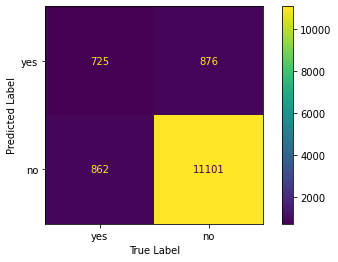

In [20]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=["yes","no"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [21]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

06-06-2022 15:51:21 Uploading figures


In [22]:
run.finish()

Acc,0.87187
F1,0.45483
Precision,0.45284
Recall,0.45684
